<a href="https://colab.research.google.com/github/JordanKeelan/data607_finalProject/blob/main/Copy_of_FinalReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis of Spanish Wine Production 

**Arthur Trim, Kane Smith, Jordan Keelan, Rodrigo Rosales Alvarez, Scott Bennett**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import math
import warnings

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.statespace.sarimax import SARIMAXResults 

from keras.models import Sequential
from keras.optimizers import Adagrad
from keras.layers import Dense, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from keras.losses import huber_loss

# Set seaborn theme for plots
sns.set_theme(style="darkgrid")

# Ignore warnings
warnings.filterwarnings("ignore")

## 1: Introduction 

### 1.1: Background and Context  

Agricultural production is the foundation of the global economy. Globally it provides jobs to over 1 billion people (Map of the month 2020) and provides food security to billions. Without agriculture, there would be no way to support our current population numbers and density. Without affordable and efficient access to food, economies world collapse. The importance of agricultural production cannot be overstated. For this project we are focused on Spanish wine production.  

Wine has always been an important beverage in society, not only for its taste and flavor; economically, wine production is a significant industry that generates billions of dollars in revenue each year. Moreover, wine is highly related with tourism, as people will travel to wineries to experience the production process and taste different varieties of wine, this has a huge positive impact on local economies, as tourism can create jobs and generate revenue for local businesses. 

Socially, wine plays an important role as it often accompanies celebrations and special occasions. Wine brings people together, creating and strengthening relationships.  

Spain is one of the most important wine-producing countries in the world and according to the International Organization of Vine and Wine (OIV), is among the top three wine-producing countries along with Italy and France. In 2020, Spain produced 1,310,174 tons of wine, accounting for 16% of the world's total wine production. 

As population continues to grow, so must food production. As we enter an era of increased variance in global temperatures, weather patterns, and natural disasters understanding the nature of food production trends will be necessary in assessing the health of our agricultural industries. Forecasting can help to inform law/policy makers, it can help to optimize resource allocation, and inform supply chains. 

Time series analysis is a statistical and machine learning technique used to model trends and forecast future values of temporal data. This type of analysis will be effective in understanding, describing, and predicting trends in agricultural data production. Time series analysis techniques such as Autoregressive Integrated Moving Average (ARIMA), Seasonal ARIMA (SARIMA), Long Short-Term Memory (LSTM) networks, and Facebook Prophet, can be employed to model and predict crop production trends. Each of these methods offers unique advantages and limitations, depending on the underlying data structure, model complexity, and forecasting requirements. 

<br>

### 1.2: Objectives of the Study  

This study aims to apply different time series analysis techniques to the FAOSTAT production indices dataset, obtained from the Food and Agriculture Organization of the United Nations (FAO), to forecast crop production trends. The results will provide insights into the most appropriate time series forecasting method for predicting crop production trends and offer valuable input for decision-making in agricultural planning and management. 

<br>

## 2: Project Dataset 

### 2.1 FAOSTAT Crops and Livestock Products Dataset 

The Food and Agriculture Organization (FAO) is a United Nations agency dedicated to leading international efforts to combat hunger. FAO's mission is to ensure food security for all, enabling individuals to have consistent access to sufficient, high-quality food to maintain active and healthy lives. 

The FAOSTAT data portal offers a diverse range of data on subjects such as food production, food security, trade, climate change, and other relevant indicators. In this study, we will concentrate on the "Crops and Livestock Products" dataset, which encompasses variables like country, year, and specific crop production data.  

<br>

### 2.2 Data Collection Process 

The FAOSTAT portal provides a user-friendly interface for data extraction, allowing both bulk data downloads and pre-filtered selections based on specific parameters. For this study, we will utilize the pre-filtering option to obtain data specific to our target crop, location, and time series for modeling purposes. The extracted data will be saved in CSV format, facilitating further manipulation and modeling using Python3. 

In [ ]:
# load main csv
wine_url = "https://raw.githubusercontent.com/JordanKeelan/data607_finalProject/main/faostat_wine.csv"
wine = pd.read_csv(wine_url)

### 2.3: Data Pre-processing 

Before starting our analysis, we cleaned up the CSV data from the FAOSTAT portal with the following steps: 
- Reviewed the columns in the data table to check for irrelevant columns. 
- Used python to check for the unique values for units in the dataset and confirmed that the wine production data is all reported in tons, with no other units appearing. 
- Converted the ‘Year’ text values into Datetime format. 
- Removed any extraneous records from the table by discarding any rows with null data in the ‘Value’ column. 
- Dropped unnecessary columns so only the Area, Year, and Value columns remain. 
- Indexed the Year column in the data tables. 

With these steps complete, we obtain cleaned data tables with annual wine production and temperature variation for our selected countries (Italy, France, Spain, and the USA).

In [ ]:
# Confirm only one unit in dataset
set(wine["Unit"].unique())

{'tonnes'}

In [ ]:
# Set datatype of Year column to datetime
wine["Year Code"] = pd.to_datetime(wine["Year Code"],format="%Y")

# Remove rows with null values in "value" column
wine = wine[wine["Value"].notna()]

# Remove unnecessary columns
wine = wine[["Area","Year Code","Value"]]

# Datetime index dataframes
wine = wine.set_index("Year Code")

## 3: Exploratory Data Analysis (EDA)   

### 3.1: Visualizations and Trends Analysis  

To begin analyzing the data, we started with a simple lineplot with the wine production for four countries, shown below. A couple interesting behaviors can be observed from this plot:

> 1. France and Italy have similar trends overall trends, declining slowly over time. They even seem to share similar local peaks and valleys.

> 2. Spain and the United States both have generally upward trends, but Spain seems to have more variance compated to the united states.

> 3. On stationarity, none are seem perfect, but France and Italy seem to have some very obvious changes to their statistical properties over time. In the first hald of the trend, both of these countries have a higher mean and higher variance. In the second half of the trend, they both have lower means and much less variance. 

> 4. Although it is still not perfect, Spain seems to have the most stationary behaviour over time out of these countries. 

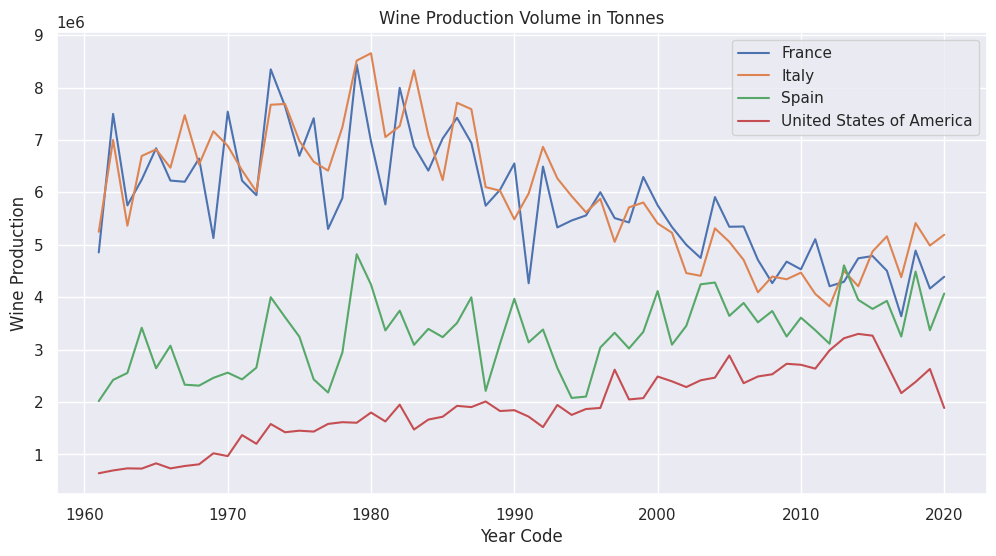

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=wine, y='Value', hue='Area',x=wine.index)
plt.title('Wine Production Volume in Tonnes')
plt.ylabel('Wine Production')
plt.legend(loc='best')
plt.show()

#3.2: Stationarity Assumption

To further understand the stationarity of the data, we created more plots for  visual analysis, and also performed an Augmented Dickey Fuller test (ADF Test) on all four countries. 

First, the statistical properties for each country over time (rolling 5 years) were plotted below. These plots clearly support the earlier observations: France, Italy and the United States have statistical properties that change significantly over time. 

Spain on the other hand is quite a lot more stable, as can be seen below:

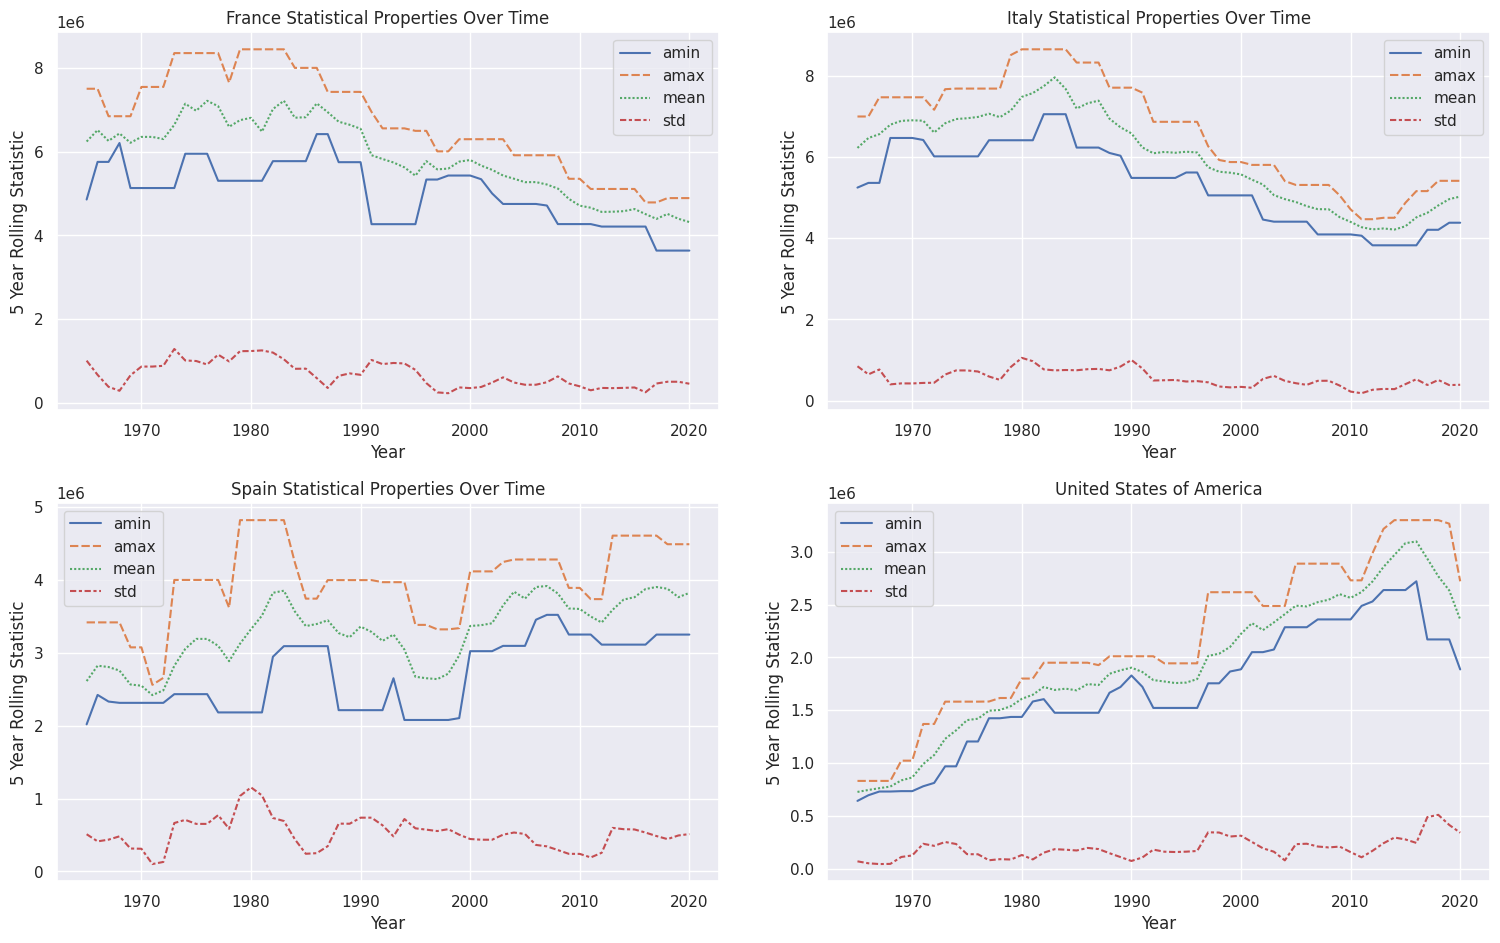

In [ ]:
# plot rolling statistics for each country
for_rolling = wine[["Area","Value"]]

countries = ["France", "Italy", "Spain", "United States of America"]

stat_features = [np.min, np.max, np.mean, np.std]

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.tight_layout(pad=3.5)

for ii, country in enumerate(countries):
    values_rolling = for_rolling[for_rolling["Area"] == country].rolling(5, min_periods=5, closed="right")
    features = values_rolling.aggregate(stat_features)
    features.columns = features.columns.get_level_values(1)
    sns.lineplot(features, ax=axs.ravel()[ii]).set(title=country+" Statistical Properties Over Time", xlabel="Year", ylabel="5 Year Rolling Statistic")
    plt.title(country)

plt.show()

After performing this thorough visual analysis, we moved on to a statistical test of stationarity, using Augmented Dickey Fuller. The null hypothesis for this test is that the time series is non-stationary, and the results can be seen for the four countries below:

In [ ]:
for country in list(wine['Area'].unique()):
    result = adfuller(wine[wine['Area'] == country]['Value'].values)
    print(f"{country} P-value: ", round(result[1], 4))

France P-value:  0.7953
Italy P-value:  0.3945
Spain P-value:  0.0001
United States of America P-value:  0.3649


Using a standard alpha value of 0.05, we reject the null hypothesis for Spain. Based on this test, Spain's series is considered stationary, but the other four countries are not. However, we can still work on the data and apply transformations to pass this test.  First we tried log transform:

In [ ]:
# Transformations
wine['Value_log'] = np.log(abs(wine.Value))
# Re-check Assumptions
for country in list(wine['Area'].unique()):
    result = adfuller(wine[wine['Area'] == country]['Value_log'].values)
    print(f"{country} P-value: ", result[1])

France P-value:  0.8155449508735089
Italy P-value:  0.33842127200067007
Spain P-value:  0.00013479339879580646
United States of America P-value:  0.10334505474703881


This transformation had mixed results. Notably, the United States' P-value dropped considerable, but still none of the countries other than Spain can be considered stationary. Next, we attempted differencing:

In [ ]:
# Transformations: Differencing
wine['Value Transform'] = 0

for country in list(wine['Area'].unique()):
    diff = np.diff(wine[wine['Area'] == country]['Value'])
    wine.loc[wine['Area'] == country, 'Value Transform'] = np.append([0], diff)

for country in list(wine['Area'].unique()):
    result = adfuller(wine[wine['Area'] == country]['Value Transform'].values)
    print(f"{country} P-value: {result[1]}")

France P-value: 3.364124615587017e-24
Italy P-value: 2.2284029970220713e-15
Spain P-value: 1.2463121912921632e-06
United States of America P-value: 9.443954124681106e-18


The differencing transofrmation was much more effective for this data. As can be seen above, all 4 countries now have a P-value less than 0.05 and we can reject the null hypothesis; these transformed values are now stationary.

We have proven that with this differencing transformation, we could proceed with any of the four countries to the next stage. 

In order to focus efforts on the number and types of models, we made the decision to proceed with Spain data, but an interesting area of future work could be to carry through with more countries and gain varied insights. 

The dataset was reduced to focus on Spain as shown below:

In [ ]:
# Isolate Spain, remove country column
wine = wine[wine['Area'] == 'Spain']
wine = wine[["Value"]]
display(wine.head())

,Value
Year Code,
1961-01-01,2018400.0
1962-01-01,2422200.0
1963-01-01,2555400.0
1964-01-01,3417500.0
1965-01-01,2645200.0


### 3.3: Seasonality and Patterns  
Seasonality is an essential aspect of many time series datasets, as it can reveal underlying patterns that influence the observed data. In the case of Spanish wine production, identifying cyclicality can provide valuable insights into the factors that drive wine production, such as climate patterns, economic cycles, and agricultural practices. We will explore the presence of cyclicality in the Spanish wine production time series data using Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. These techniques can help us determine the period of the recurring cycles in the data, which will then inform our time series decomposition and Seasonal Autoregressive Integrated Moving Average (SARIMA) modeling.

The Autocorrelation Function (ACF) plot is used to identifying cyclicality in time series data. By showing the correlation between a time series and its lagged values, the ACF plot can reveal the presence of recurring cycles. In the context of Spanish wine production data, significant peaks at specific lags in the ACF plot would indicate the existence of cyclical patterns. These peaks can help us determine the period of the cycles, which is crucial for both time series decomposition and SARIMA modeling (Monigatti, 2022). 

In the ACF plot below, cycles become more apparant at the halfway point of the chart, with the dominant cycle displaying a 3-4 year period. 

The Partial Autocorrelation Function (PACF) plot is another method for exploring cyclicality in time series data. The PACF plot displays the correlation between a time series and its lagged values after accounting for the influence of previous lags. Like the ACF plot, the presence of significant peaks at particular lags in the PACF plot can indicate the existence of cyclical patterns in the data. Identifying the period of these cycles using the PACF plot can provide complementary information to the ACF analysis. 

In the PACF chart below, as in the ACF plot, cycles become more apparent at the halfway point of the chart, with the dominant cycle displaying a 3-4 year period. 

For the ACF and PACF plots, we chose to use 20 lags as a reasonable value that would provide coverage to detect potential cycles spanning 2-7 years or more in the data.


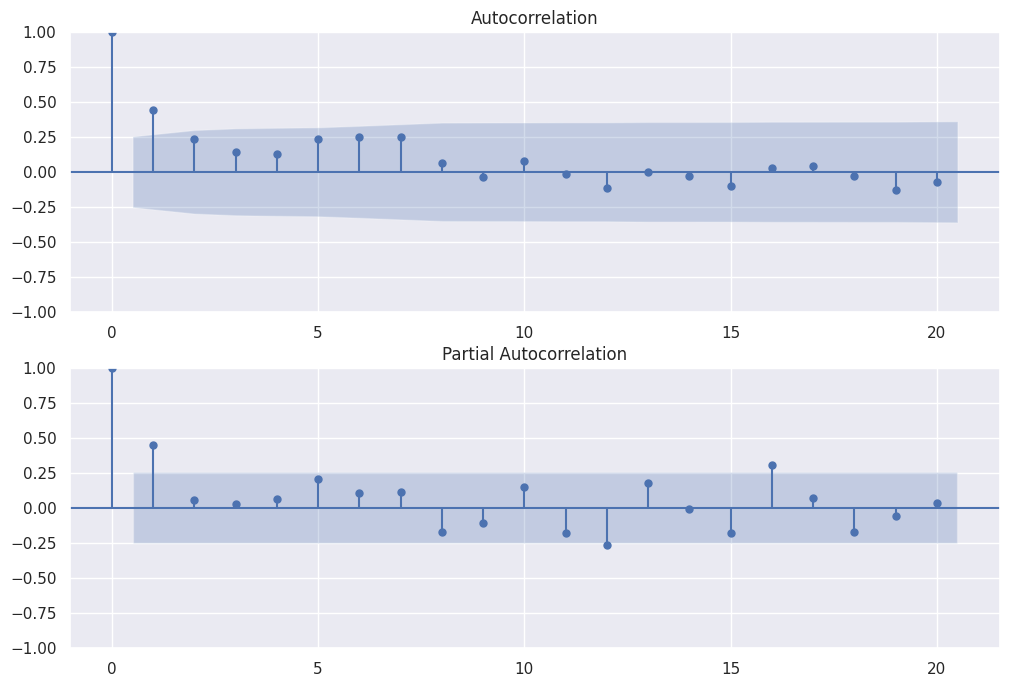

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(wine, lags=20, ax=ax1)

# PACF plot
plot_pacf(wine, lags=20, ax=ax2)

plt.show()


### 3.4 More on ACF and PACF

#### Autocorrelation Function (ACF)
Measures the correlation between a time series and its lagged values at different time lags. Each bar represents the size and direction of the correlation.
- Identify patterns in the time series data: identify periodicity or seasonality in the time series data. 
- Test for stationarity: a stationary time series is one whose statistical properties, such as the mean and variance, do not change over time. If the ACF shows a slow decay or a trend, this suggests that the time series is non-stationary.
- Model selection: The ACF can help in selecting appropriate models for time series forecasting. For example, if the ACF shows a significant correlation at lag 1, an autoregressive model may be appropriate. If the ACF shows a significant correlation at lag 12, a seasonal autoregressive model may be appropriate.
- Detect outliers: The ACF can help detect outliers or unusual data points in the time series. If an observation has a large autocorrelation coefficient at a particular lag, this indicates that it is strongly related to previous observations at that lag and may be an outlier.

The shaded region is a confidence interval - if the height of the bars is outside this region, it means the correlation is statistically significant.

#### Partial autocorrelation function (PACF)
Identifies the degree of correlation between a time series and its lagged values, after controlling for the effects of all shorter lags. Is a useful tool for identifying the order of autoregressive models in time series analysis.

The PACF plot identifies the order of autoregressive (AR) models, which capture the dependence of a time series on its own past values, the PACF plot can help identify the number of significant lags in an AR model.

In practice, the PACF plot is often used in conjunction with the ACF plot to develop and refine time series models. For example, if the PACF plot shows a significant spike at lag k, and no significant spikes at higher lags, this suggests that an AR model of order k may be appropriate for the data. Conversely, if the PACF plot shows significant spikes at multiple lags, this suggests that a more complex AR model may be necessary to capture the dependence in the data.

This method tries to account for the effect the intervening lags have. For example, at lag 3, partial autocorrelation removes the effect lags 1 and 2 have on computing the correlation.

## 4: Time Series Decomposition  

Time series decomposition involves breaking down a time series into its key components: linear trend, seasonality, and residual. This approach can help us gain a more comprehensive understanding of the underlying patterns in the Spanish wine production data, and better inform our selection of algorithms for modeling and forecasting (Brownlee, 2020).

### 4.1: Additive vs Multiplicative

When using the "seasonal_decompose" function to perform time series decomposition, we need to specify whether the relationship between the linear trend and seasonal components is additive or multiplicative. Additive relationships have a constant cycle amplitude, while multiplicative relationships involve the cycle amplitude expanding or contracting with the increasing linear trend. Based on visual inspection of our data, there is no significant difference between additive and multiplicative relationships. We will assume an additive relationship for our analysis (Brownlee, 2020). 

### 4.2: Trend Component  

The trend component of the data reflects the overall linear direction and velocity of wine production. Ideally, this component should display a straight line that either increases or decreases uniformly over time. However, our decomposition results indicate that achieving perfect linearity is difficult. We observed that increasing the period length can improve linearity but at the cost of more erratic seasonality (Brownlee, 2020).  

### 4.3: Seasonal Component  

We determined the appropriate period length to enter into the "seasonal_decompose" function using the 3-4 year period identified in our ACF and PACF charts. The ideal shape of this component is a regularly repeating cycle. We found that the seasonal component was optimized at 3 or 5 year cycles. However, choosing these lower cycle periods resulted in a non-linear trend component. This indicates that there is likely more than one seasonal cycle component that comprises this data (Brownlee, 2020). 

### 4.4: Residual Component 

The residual component represents all of the variation in the data that cannot be explained by the trend and seasonal components. Ideally, this component should be random noise with no discernible structure. However, we found that even at all period levels and under both additive and multiplicative relationships, there was some form of repeating structure present in the data. This further informs us of the presence of unaccounted for variation (Brownlee, 2020).

### 4.5: Decomposition Conclusions

From examining the interactions between trend, seasonal, and residual components, it is evident that our data has more complex patterns occurring than can be explained by a single seasonal component. Given the broad topic of wine production in Spain and the numerous factors that can influence production values, a comprehensive decomposition would likely require the extraction of at least one more seasonal component to fully describe the variation observed in the data. 

As our decomposition did not yield an obvious cyclical period, we will rely on grid searching to optimize this value in subsequent models.  We also acknowledge that it is likely we would need to reply on more complex models that can take into account exogenous variables, such as weather or economic metrics, or that factor in the presence of multiple interacting cycles. 


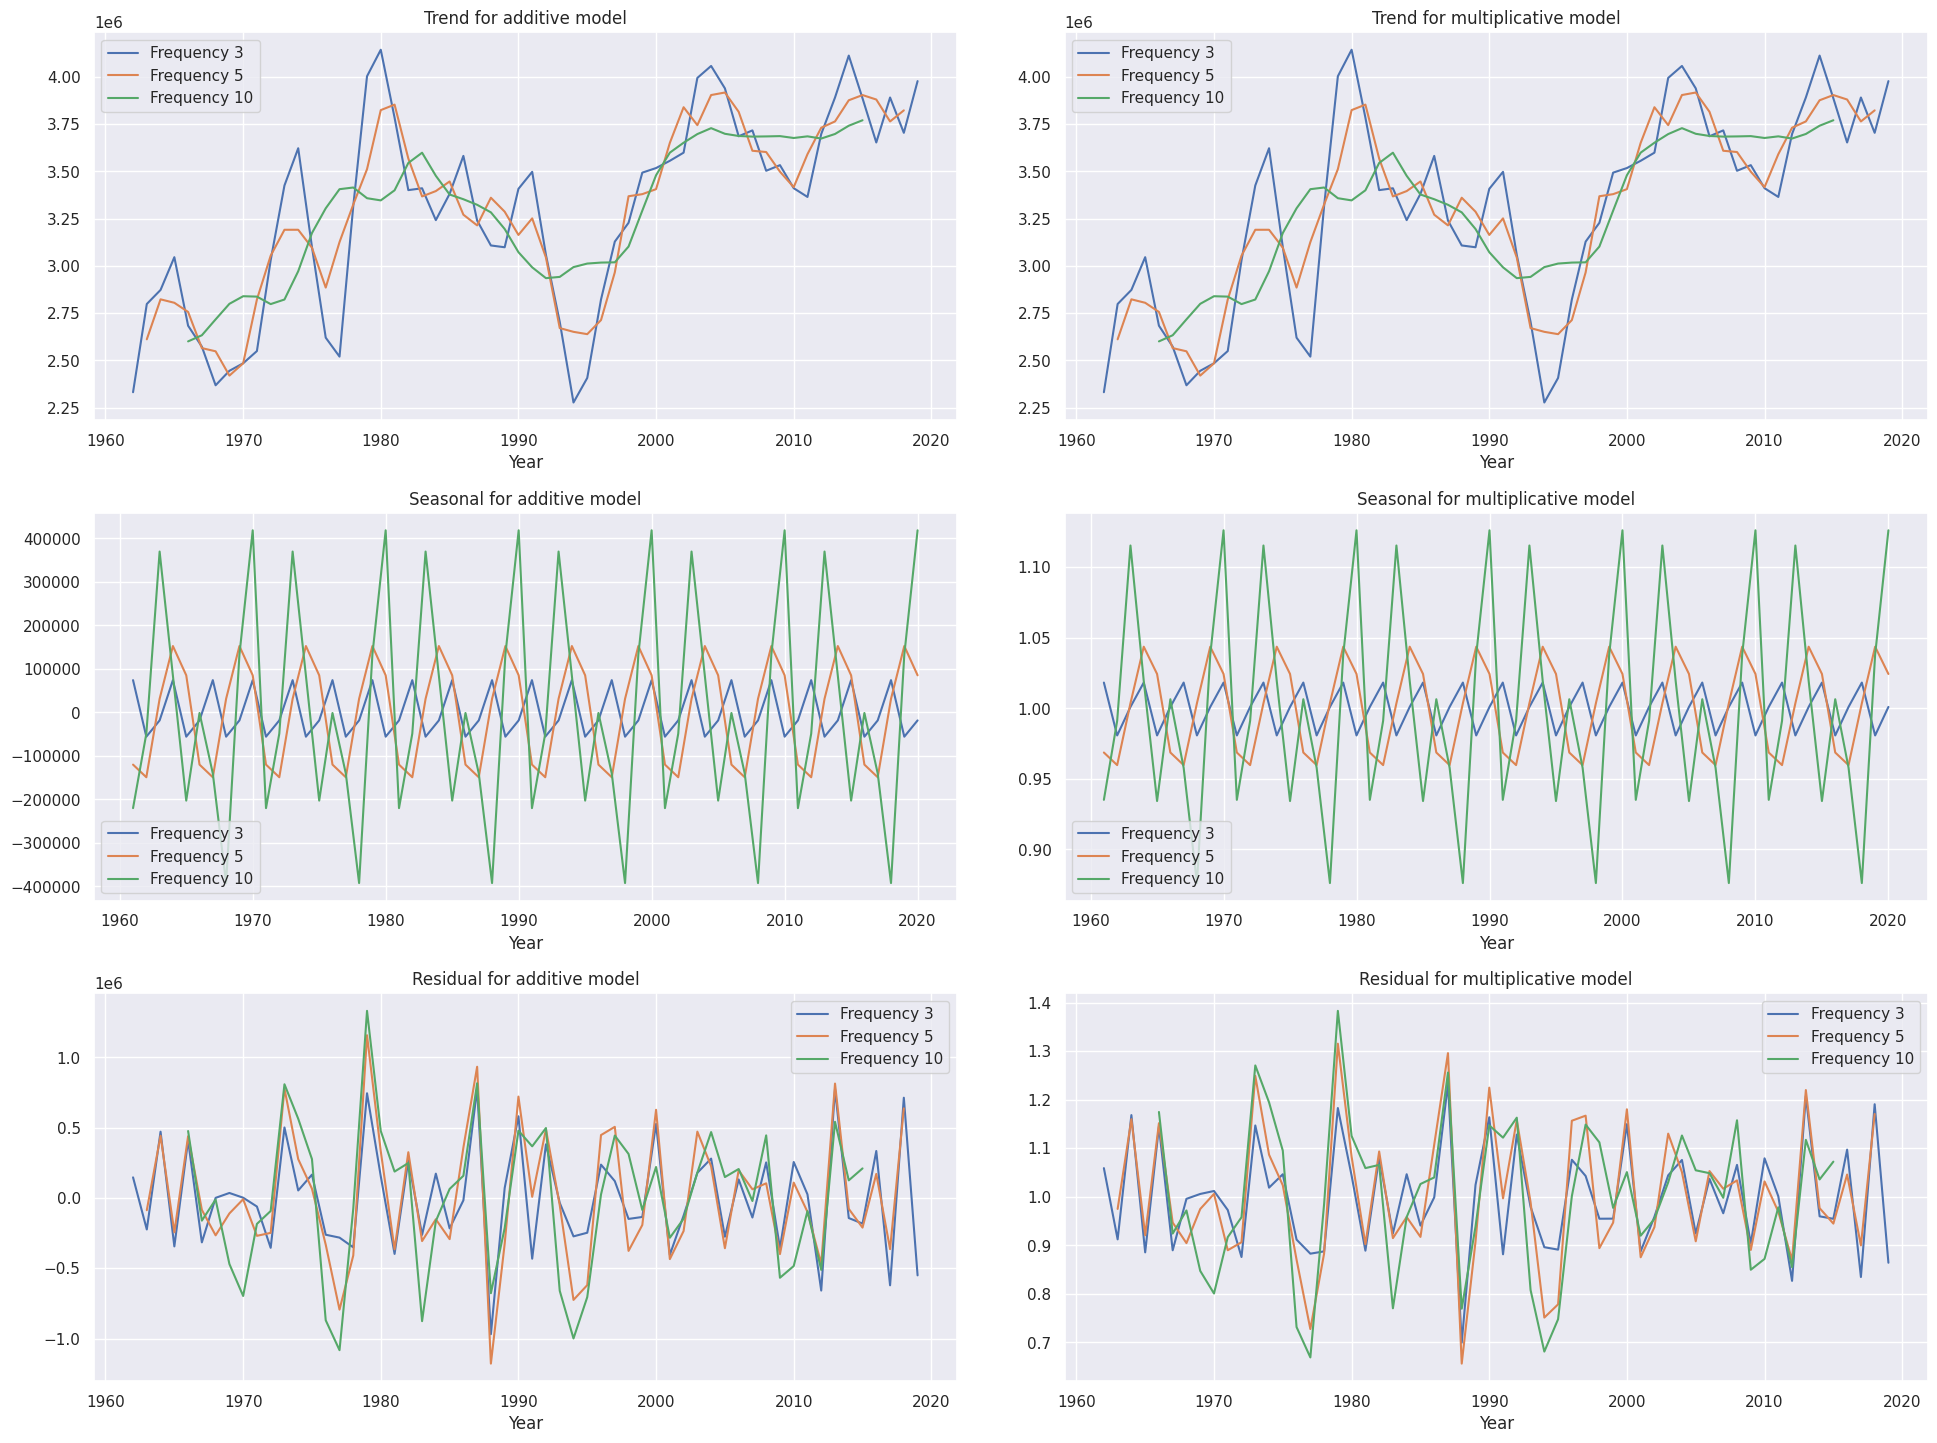

In [ ]:
# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequencies = [3, 5, 10] #4, 15]

fig, axs = plt.subplots(3, 2, figsize=(20, 15))
fig.tight_layout(pad=3.5)
for ii, model in enumerate(['additive', 'multiplicative']):
    for frequency in frequencies:
        decomposition = seasonal_decompose(wine.Value, model=model, period=frequency)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid

        sns.lineplot(x=trend.index, y=trend.values, ax=axs[0,ii], label="Frequency "+str(frequency)).set(title="Trend for " + model + " model", xlabel="Year")
        sns.lineplot(x=seasonal.index, y=seasonal.values, ax=axs[1,ii], label="Frequency "+str(frequency)).set(title="Seasonal for " + model + " model", xlabel="Year")
        sns.lineplot(x=residual.index, y=residual.values, ax=axs[2,ii], label="Frequency "+str(frequency)).set(title="Residual for " + model + " model", xlabel="Year")

#sns.lineplot(x=decomposition.observed.index, y=decomposition.observed.values, ax=axs[0,0], label="original")

plt.legend()
plt.show()

## 6: Model Development




### 6.1: ARIMA Model  

Autoregressive Integrated Moving Average is a type of time series model used to analyze and forecast future values of a time series based on its past behavior, or lagged values. It is important to stablish that this model does not consider seasonality of the data.  

The ARIMA model is composed of three components:  
- Autoregressive Component: represents the correlation between the current value of the time series and its past values. 
- Integrated Component: represents the differencing of the time series to make it stationary. 
- Moving Average Component: represents the correlation between the current value and the errors of past predictions. 

ARIMA models are widely used in different industries like finance, economics, and other fields where forecasting is important; also, is widely used for outlier detection.  

The most important assumption of the ARIMA model is that the data is stationary, in other words that the mean and variance of the data remains constant over time. To prove it, we used the Augmented Dickey-Fuller test, this test has a Null Hypothesis that the data is non-stationary. We obtained a p_value of 0.00007, meaning that we can reject the Null, and state that our data presents stationarity.  

To implement the ARIMA model in python we used the *ARIMA* class present in the *statsmodels.tsa.arima.model* module as it provides a convenient way to fit an ARIMA model into a time series analysis and offers the possibility to forecast and evaluate the model.  

**6.1.2: Parameter Selection**

Three parameters that are important to build an ARIMA model are: 
- P: represents the number of lagged values of the time series that are included in the model. 
- Q: represents the number of lagged errors of the time series that are included in the model. 
- D: represents the number of times that the time series is differenced to achieve stationarity. 

Grid Search is a technique used for hyperparameter tuning in machine learning models, in other words is a method for systematically testing different combinations of hyperparameters to identify the best set of parameters for a given model. We found that the best parameters for our model are p=4, q=3, d=2. 

**6.1.2: Model Fitting**  

To train our model, we used annually wine production in Spain from 1961 to 2010 and used data from 2011 to 2020 to test our model. Please check the Appendix A, section ARIMA to review the code we implemented.  

Here below, we can observe the real production of wine in Spain in pink and the predicted value from our ARIMA model in blue. As we can see, our prediction follows the general trend of the data. 

Best parameters: (4, 2, 3)
Lowest MAE: 362060.00


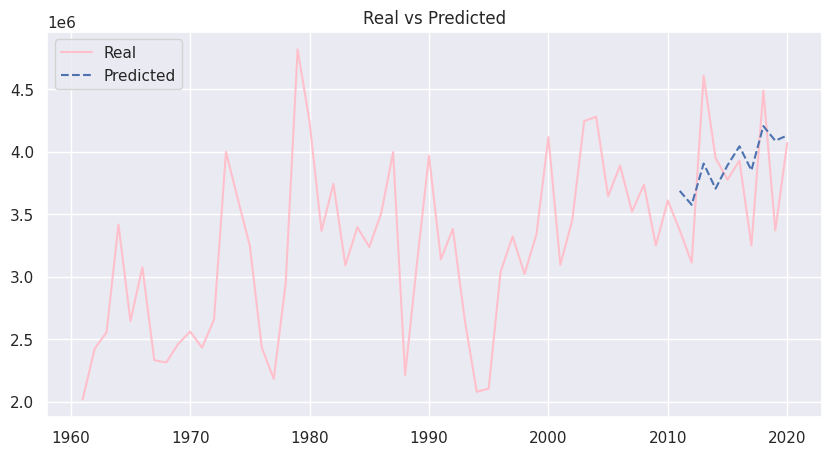

In [ ]:
# Grid Search ARIMA
country = 'Spain'
value = 'Value'

# Prepare the training and testing data
train = wine.iloc[0:50]
test = wine.iloc[50:]

# Define the range of p, d, q, P, D, and Q values
p = range(0, 6)
d = range(0, 3)
q = range(0, 6)

# Generate all possible combinations of p, d, q
parameter_combinations = list(itertools.product(p, d, q))

# Initialize the best model parameters and the lowest MAE
best_parameters = None
lowest_mae = float("inf")

# Train and evaluate models for each combination
for parameters in parameter_combinations:
    p, d, q = parameters
    try:
        # Fit the SARIMAX model
        model = ARIMA(train[value], order=(p, d, q))
        model_fit = model.fit()

        # Make predictions
        predictions = model_fit.predict(start=test[value].index[0], end=test[value].index[-1], typ='levels')

        # Calculate the Mean Absolute Error
        mae = mean_absolute_error(test[value], predictions)

        # Update the best parameters if the current MAE is lower than the previous lowest MAE
        if mae < lowest_mae:
            lowest_mae = mae
            best_parameters = parameters
    except:
        continue

# Print the best parameters and the lowest MAE
print(f"Best parameters: {best_parameters}")
print(f"Lowest MAE: {lowest_mae:.2f}")

# Plot best parameters
arima_model = ARIMA(train[value], order = best_parameters) 
arima_model_fit = arima_model.fit()
predicted_values = arima_model_fit.predict(start=test[value].index[0], end=test[value].index[-1], typ='levels')
output = pd.concat([predicted_values, test[value]], axis=1, join="inner")

plt.figure(figsize=(10,5))
real = plt.plot(wine[value], color='pink',label='Real')
predicted = plt.plot(output.iloc[:,0], color='b', label='Predicted', linestyle='--')
plt.title('Real vs Predicted')
plt.legend(loc='best')
plt.show()

**6.1.3: Performance Evaluation**

Mean Absolute Error (MAE) is used to measure the accuracy of time series forecasting models. It measures the average absolute difference between the predicted and actual values over a given period; a lower value of MAE is desired, which would mean that the model has better accuracy for time series forecasting. For our ARIMA model we got a MAE of 362,190.09 tones of wine.  

<br>

### 6.2: SARIMA Model  
Seasonal Autoregressive Integrated Moving Average (SARIMA) is an extention of the ARIMA model which takes into acount the presence of seasonality in the data. As our Time Series Decomposition highlighted the potential for seasonality in our time series, should seasonality exist within the Spanish wine production time series this model should improve accuracy of predictions and forecasting. 

The SARIMA algorithm used for our purposes is the SARIMAX function from the statsmodels Python library. SARIMAX adds the 'X' to the SARIMA acronym, meaning eXogenous, as it is capable of taking inputs from exogenous variables (Statsmodels), an argument we will not be utilizing but is an excellent candidate for continued work.  



#### 6.2.1: Parameter Selection  
SARIMA combines AR (AutoRegressive), I (Independent), and MA (Moving Average) with their seasonal counterparts. Where ARIMA's parameters were p, d, q, SAIMA's parameters adds their seasonal counterparts P, D, and Q as well as the seasonal period s. All of these parameters are tuned in our model using Grid Search methodology. 

- P - Seasonal Autoregressive: This parameter is similar to 'p' but applied to the seasonal component of the model. It represents the number of seasonal lags used in the seasonal autoregressive component. 
- D - Seasonal Differencing: Similar to 'd,' this parameter is used to make the seasonal component of the time series stationary. The data is differenced 'D' times at seasonal intervals.
- Q - Seasonal Moving Average order: This parameter is similar to 'q' but applied to the seasonal component of the model. It represents the number of seasonal error terms used in the seasonal moving average component. 
- s - Seasonal period: This parameter indicates the length of the seasonal cycle in the data. For our annual data, we expect this

Grid Search Value Ranges:

| Parameter       | Value Range | GS Optimal Value |
|-----------------|-------------|------------------|
|        p        |    0-3      |        2         |
|        q        |    0-3      |        1         |
|        d        |    0-3      |        1         |
|        P        |    0-3      |        1         |
|        Q        |    0-3      |        1         |
|        D        |    0-3      |        0         |
|        s        |    2-15     |        5         |


####6.2.3: Model Fitting

In [ ]:
# Prepare the training and testing data
training = wine[(wine.index > "1960-01-01") & (wine.index < "2011-01-01")][value]
testing = wine[~wine.index.isin(training.index)][value]

# Define the range of p, d, q, P, D, and Q values
p_range = range(0, 3)
d_range = range(0, 3)
q_range = range(0, 3)
P_range = range(0, 3)
D_range = range(0, 3)
Q_range = range(0, 3)
s_range = range(2, 16)

# Generate all possible combinations of p, d, q, P, D, and Q values
parameter_combinations = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range, s_range))

# Initialize the best model parameters and the lowest MAE
best_parameters = None
lowest_mae = float("inf")

# Train and evaluate models for each combination
for parameters in parameter_combinations:
    p, d, q, P, D, Q, s = parameters
    try:
        # Fit the SARIMAX model
        model = SARIMAX(training, order=(p, d, q), seasonal_order=(P, D, Q, s))
        model_fit = model.fit()

        # Make predictions
        n_test = len(testing)
        predictions = model_fit.forecast(steps=n_test)

        # Calculate the Mean Absolute Error
        mae = mean_absolute_error(testing, predictions)

        # Update the best parameters if the current MAE is lower than the previous lowest MAE
        if mae < lowest_mae:
            lowest_mae = mae
            best_parameters = parameters
    except:
        continue

# Fit the best SARIMAX model using the best parameters
best_p, best_d, best_q, best_P, best_D, best_Q, best_s = best_parameters
best_model = SARIMAX(training, order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, best_s))
best_model_fit = best_model.fit()

# Make predictions with the best model
n_test = len(testing)
best_predictions = best_model_fit.forecast(steps=n_test)

# Print the best parameters and the lowest MAE
print(f"Best parameters: {best_parameters}")
print(f"Lowest MAE: {lowest_mae:.2f}")

#### 6.2.3: Performance Evaluation 

After Grid Search and optimal parameter model fitting, the optimal model has produced a Mean Average Error of 266260.98 Tonnes of Wine Production.  This equates to 

In [ ]:
# Plot the actual and predicted values
plt.figure(figsize=(10,5))
plt.plot(testing.index, testing, label='Actual', color='blue')
plt.plot(testing.index, best_predictions, label='Predicted', color='red')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Plot the actual and predicted values
plt.figure(figsize=(10,5))
plt.plot(wine.index, wine, label='Actual', color='blue')
plt.plot(testing.index, best_predictions, label='Predicted', color='red')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()

# Show the plot
plt.show()

##### 6.2.3.1 Ljung-Box Test

The Ljung-Box Test (LB test) is a way to test for the absence of serial autocorrelation, up to a specific lag, k (Stephanie, 2020). The test determines weather or not errors are white noise or if there is structure behind them. 

The null hypothesis for the LB test is that our model does not show lack of fit (the model is successful). The alternative hypothesis states that there is significant evidence that the model does show a lack of fit (Stephanie, 2020).

Unfortuantely our results conclusively show p-values well above significance at all lags. Though our predictions look promising in relation to other models in this study, we are certainly not explaining all variance with our model. 

In [ ]:
# Get the residuals
residuals = best_model_fit.resid

# Perform the Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=20)  # 20 lags to be consistent with above

# Print the results
print("Ljung-Box test results:")
print("P-values: \n", p_values)

### 6.3: LSTM Networks  

We wanted to create a proof-of-concept neural network for our time series analysis to show ourselves how it would be implemented. Due to the simplicity of it's structure, we did not expect it to outperform some of our other models.

LSTM stands for Long Short-Term Memory and is a type of recurent neural network that can be used for time series analysis. The LSTM can take a sequence of previous observations and then predict the next value of the sequence. One of the benefits of using a neural network for time series analysis is it can learn compelx patterns in the data if you have enough data and you tune it correctly; the downside is that it can computationally expensive. Because of this, we we only made a simple LSTM and only searched a small hyperparameter space for tuning the model.

**6.3.1: Hyperparameter Selection**

In TensorFlow's implementation of LSTM, there are many parameters we can tune to try to improve the model. 

- Epochs: The number of times the dataset is presented to the model during training. The more epochs, the more computation it will take to train.
- Batch size: The number of training examples used in one iteration of the training process.
- Neurons: The number of neurons in a layer of the LSTM.
- Dropout rate: A regularization technique that randomly drops out some neurons from the model to avoid overfitting.
- Learning rate: The magnitude of updates made to model in resonse to the loss function output.
- Optimizer: The optimization algorithm used to minimize the loss function.

To keep things simple since we did not have a lot of time to run our model, we set epochs to 100, batch size to 1, dropout rate to, neurons to 300 and the optimization algorithm to 'adagrad'. We then used GridSearch to find the best combination in the paramter space of learning_rate = [0.001, 0.01, 0.1].

<br>

**6.3.2: Data Pre-processing** 

In [ ]:
spain_df = wine[wine["Area"] == "Spain"]
df = spain_df.drop(["Unnamed: 0", "Value_log", "Value Transform", "Area"], axis = 1).reset_index(drop=False)
data = df[['Value']].values

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# split data into train and test sets
train_size = len(data) - 14
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

# create function to convert data into time series dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# convert data into time series dataset
look_back = 3
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

**6.3.2: Model Training**  

In [ ]:
# create LSTM model
def create_model(lr=0.001):
    model = Sequential()
    model.add(LSTM(300, dropout=0.1, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adagrad')
    return model

# create KerasRegressor
model = KerasRegressor(build_fn=create_model)

# define hyperparameters to search over
params = {'lr': [0.001, 0.01, 0.1]}


grid = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

# fit the grid search
grid_result = grid.fit(X_train, Y_train, batch_size=1, verbose=0)

# print the best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# retrain the model on the best hyperparameters
best_lr = grid_result.best_params_['lr']

model = create_model(lr=best_lr)
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

**6.3.3: Performance Evaluation** 

In [ ]:
train_score = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
test_score =mean_squared_error(Y_test[0], test_predict[:,0])
print("Test MAE: ", test_score)


dates = ["2011-01-01", "2012-01-01", "2013-01-01","2014-01-01","2015-01-01","2016-01-01","2017-01-01", "2018-01-01", "2019-01-01", "2020-01-01"]
pred_df = pd.DataFrame(data=test_predict, index = dates, columns=["y_pred"])

plt.figure(figsize=(10,5))
real = plt.plot(spain_df["Value"], color="pink", label="real")
predicted = plt.plot(pred_df["y_pred"], color = "b", linestyle='--', label="predicted")
plt.legend(loc="best")
plt.show()

Our model gives us a MAE of 467,686.06 tonnes, which as we expected is worse compared to our ARIMA and SARIMA models. If we had more time to tune our model structure and hyperparameters, we would expect the LSTM to perform much better.

## 7: Model Comparison and Selection  

### 7.1: Model Performance Metrics Comparison  



### 7.2: Best Model Selection



## 8: Forecasting and Visualization  

Now that the models have been trained and tested, we have determined that the SARIMA model has the best performance. To produce a future forecast (beyond the available data), we decided to retrain the SARIMA model using all available data (1960-2020) and use that model to produce a 20 year forecast.

The plot below shows the dotted forecast from 2021-2030. From a purely visual perspective, it seems to match the general pattern and trend of the raw data quite well. Of course, this model predicts a stable trend, and stable seasonal cycle.

When the confidence interval is visualized to this prediction, we see that within just a few year the confidence interval eclipses the entire spread of all historical data.  So while these results are visually appealing, there is much consideration to be made regaurding how to improve this model to yeild actionable results. 

Although we don't have data for 2021 (the first year of the forecast), we could speculate that this might be an abnormal year due to COVID-19. This is a great reminder that the performance of a time-series model such as this will not help predict black swan/outlier events, and performance will be lower in those cases. 

### 8.1: Future Crop Production Forecast

In [ ]:
# Forecast 10 years into the future
steps = 10
forecast_obj = best_model_fit.get_forecast(steps=steps)
forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

# Print results
print(f"\n{steps}-year forecast:")
print(forecast)

# Plot the FAOSTAT data and forecasts
plt.plot(data.index, data, label='FAOSTAT', color='blue')

forecast_start = forecast.index[0]
forecast_end = forecast.index[-1]
plt.plot(forecast.index, forecast, label=f'{steps}-year forecast', linestyle='--')

# Add confidence intervals
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.5, label='95% Confidence Interval')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Historical Data and Forecasts')
plt.legend()

# Set the x-axis format to display the years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Show the plot
plt.show()

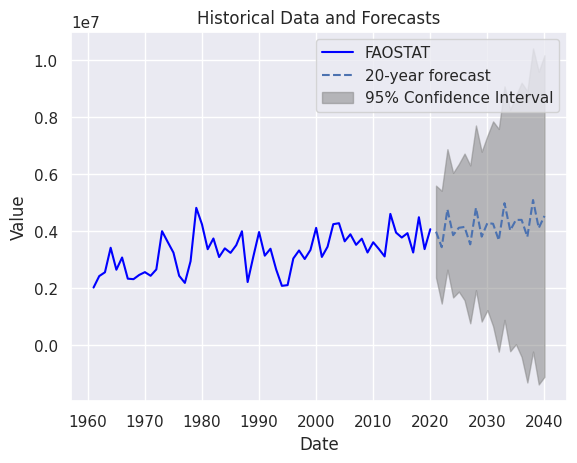

In [ ]:
import matplotlib.dates as mdates


# Forecast 20 years into the future
steps = 20
forecast_obj = best_model_fit.get_forecast(steps=steps)
forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

# Plot the FAOSTAT data and forecasts
plt.plot(data.index, data, label='FAOSTAT', color='blue')

forecast_start = forecast.index[0]
forecast_end = forecast.index[-1]
plt.plot(forecast.index, forecast, label=f'{steps}-year forecast', linestyle='--')

# Add confidence intervals
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.5, label='95% Confidence Interval')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Historical Data and Forecasts')
plt.legend()

# Set the x-axis format to display the years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Show the plot
plt.show()


## 9: Conclusion and Future Work  


### 9.1: Summary of Findings  

Through exploratory data analysis, we were able to identify patterns in the data of wine production inlcuding seasonality. We also idenitifed stationarity (or lack of stationarity) in several countries and had success to correct this issue using differencing to transform the data.

Next, several time series models were produced for predicting wine produciton in Spain. These included ARIMA, SARIMA and LSTM. We fitted, tuned and compared the performance of these models. The SARIMA model had the best performance and this model was used to generate a 20 year forecast along with confidence intervals. 

The result of the forecast visually appeared to match the past patterns well, but the relatively wide confidence intervals and results of the Ljung-Box Test suggest that there is room for improvement. With more work and more data, these models could hopefully be improved.

### 9.2: Future Research Directions 


In the future we would like to explore other the important wine productors in the world like Italy, France and the United States to see if they behave similarly and if models created for those countries perform similarly to Spain.

To improve performance of the models and understanding of the data, we would also like to include exogenous variables in the analysis as they provide additional information. Examples of this could be temperature and rainfall, as some growing grape regions (including Spain) have had to adapt to higher temperatures from climate change, and droughts can devastate their harvest (Sulleiro, n.d.); these are likely to be important factors. Inclusion of these exogenous factors might be able to further improve model performance, or lead to deeper insight on some of our observed behavior like seasonality. 

Lastly, we would like to do more research or consult subject matter experts who might be able to offer practical reasons for the patterns we have identified. Along the same lines, it would be ideal to leverage expertise who could identify particular outlier events (like drought or disease) which we could exclude from training. This type of information would most likely require the combination of a subject matter expert and more data, due to the regional nature of wine production. 

<br>

## 10: References 
- Bajaj, A. (2023, January 26). Arima & Sarima: Real-world time series forecasting. neptune.ai. Retrieved March 22, 2023, from https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide  
- Bonaros, B. (2022, July 4). Time series decomposition in Python. Medium. Retrieved March 22, 2023, from https://towardsdatascience.com/time-series-decomposition-in-python-8acac385a5b2  
- FOASTAT Crops and livestock products. Faostat. (n.d.). Retrieved March 22, 2023, from https://www.fao.org/faostat/en/#data/QCL 
- Hayes, A. (2023, January 5). Autoregressive integrated moving average (ARIMA) prediction model. Investopedia. Retrieved March 22, 2023, from https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp  
- Kalita, D. (2022, March 24). An overview on Long short term memory (lstm). Analytics Vidhya. Retrieved March 22, 2023, from https://www.analyticsvidhya.com/blog/2022/03/an-overview-on-long-short-term-memory-lstm/  
- Map of the month: How many people work in agriculture? Resource Watch Blog. (2020, May 4). Retrieved March 22, 2023, from https://blog.resourcewatch.org/2019/05/30/map-of-the-month-how-many-people-work-in-agriculture/#:~:text=The%20chart%20below%20shows%20data,down%20from%2044%25%20in%201991.  
- Quick start. Prophet. (2023, February 28). Retrieved March 22, 2023, from https://facebook.github.io/prophet/docs/quick_start.html 
- El Niño Southern Oscillation (ENSO) region sea surface temperature forecasts. https://www.metoffice.gov.uk/research/climate/seasonal-to-decadal/gpc-outlooks/el-nino-la-nina#:~:text=Some%20regions%20have%20impacts%20that,the%20text%20on%20the%20map. 
- Brownlee, J. (2020, December 9). How to decompose time series data into trend and seasonality. MachineLearningMastery.com. Retrieved April 9, 2023, from https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/ 
- Monigatti, L. (2022, August 2). Interpreting ACF and PACF plots for time series forecasting. Medium. Retrieved April 9, 2023, from https://towardsdatascience.com/

- Sulleiro, R. (n.d.). Uphill battle: Spain’s wine growers adapt to climate change. Phys.org. https://phys.org/news/2021-09-uphill-spain-wine-growers-climate.html

- Statsmodels.tsa.statespace.sarimax.SARIMAX. statsmodels. (n.d.). Retrieved April 9, 2023, from https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html 

- Stephanie. (2020, June 8). Ljung box test: Definition. Statistics How To. Retrieved April 9, 2023, from https://www.statisticshowto.com/ljung-box-test/ 